In [108]:
# Importing neccessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.relativedelta import relativedelta
import missingno as msno
from fancyimpute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn import over_sampling, under_sampling, combine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from xgboost import XGBClassifier
%matplotlib inline

In [4]:
# Reading data from csv and converting as dataframe
# Taking intial look at the data

bank_df = pd.read_csv('train.csv', parse_dates=['DOB', 'Lead_Creation_Date'])
bank_df.head()

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,1979-07-23,2016-07-15,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,Male,1986-07-12,2016-04-07,C10003,A,COM0000002,C,1.0,3500.0,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,Male,1982-10-12,2016-07-19,C10125,C,COM0005267,C,4.0,2250.0,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0
3,APPF80273865537,Male,1989-01-30,2016-09-07,C10477,C,COM0004143,A,4.0,3500.0,...,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0
4,APPG60994436641,Male,1985-04-19,2016-07-20,C10002,A,COM0001781,A,4.0,10000.0,...,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0


In [5]:
# Dropping ID feature because it doesn't contribute any value to our analysis

bank_df.drop(['ID'], axis=1, inplace=True)

In [6]:
# Getting the info about datatype of features and checking for any null values present in the feature 

bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69713 entries, 0 to 69712
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Gender                               69713 non-null  object        
 1   DOB                                  69698 non-null  datetime64[ns]
 2   Lead_Creation_Date                   69713 non-null  datetime64[ns]
 3   City_Code                            68899 non-null  object        
 4   City_Category                        68899 non-null  object        
 5   Employer_Code                        65695 non-null  object        
 6   Employer_Category1                   65695 non-null  object        
 7   Employer_Category2                   65415 non-null  float64       
 8   Monthly_Income                       69713 non-null  float64       
 9   Customer_Existing_Primary_Bank_Code  60322 non-null  object        
 10  Primary_Ba

In [7]:
# converting Approved and Employer_Category2 feature to their appropriate datatypes

bank_df['Approved'] = bank_df['Approved'].astype(object)
bank_df['Employer_Category2'] = bank_df['Employer_Category2'].astype(object)

In [8]:
mask = bank_df[(bank_df.DOB.dt.year >= 2016)].index
bank_df.loc[mask,'DOB'] = np.NaN

In [9]:
# Creating Age at the time of lead creation from the DOB

bank_df['Age'] = round((bank_df.Lead_Creation_Date - bank_df.DOB) / np.timedelta64(1, 'Y'), 0)

In [10]:
# Dropping DOB, as age is calculated from that

bank_df.drop(['DOB'], axis=1, inplace=True)

In [11]:
# Getting summary of numerical features to check for any abnormalities

bank_df.describe()

,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Age
count,6.971300e+04,69662.000000,42004.000000,42004.000000,22276.000000,22276.000000,69713.000000,66665.000000
mean,5.622283e+03,360.928751,39429.982859,3.890629,19.213570,1101.466242,3.948446,29.844251
std,1.747671e+05,2288.517927,30727.595990,1.167491,5.847136,752.661394,3.819214,5.472729
min,0.000000e+00,0.000000,5000.000000,1.000000,11.990000,118.000000,0.000000,17.000000
25%,1.650000e+03,0.000000,20000.000000,3.000000,15.250000,649.000000,0.000000,26.000000
50%,2.500000e+03,0.000000,30000.000000,4.000000,18.000000,941.000000,2.000000,29.000000
75%,4.000000e+03,350.000000,50000.000000,5.000000,20.000000,1295.000000,7.000000,33.000000
max,3.838384e+07,545436.500000,300000.000000,6.000000,37.000000,13556.000000,10.000000,47.000000


**Key Inferences**

1. Observations with monthly income of 0 is available and will be not eligible for loan. 
2. Max monthly income need to be investigated.
3. Max EMI need to be investigated.

In [12]:
# Getting summary for categorical features

bank_df.describe(include=object)

,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Approved
count,69713,68899,68899,65695,65695,65415.0,60322,60322,69713,69713,69713,69713
unique,2,678,3,36617,3,4.0,57,2,2,29,7,2
top,Male,C10001,A,COM0000002,A,4.0,B001,P,Y,S122,B,0
freq,39949,10007,49885,457,33336,57582.0,14197,39619,45275,30941,29812,68693


**Inferences**
1. City Code, Employer_code, Customer_Existing_Primary_Bank_Code, Source are having high cardinality.
2. In Approved (Target Variable) frequency of '0' high indicating class labels are imbalanced.

In [13]:
'''Dropping the below variables because of high cardinality and also the information is captured high level by 
other associated features City_Category, Employer_Category, Primary_Bank_Type and Source_Category.'''

bank_df.drop(['City_Code', 'Employer_Code', 'Customer_Existing_Primary_Bank_Code', 'Source'], axis=1, inplace=True)

In [14]:
# Getting count of class labels in target variable

bank_df.Approved.value_counts()

0    68693
1     1020
Name: Approved, dtype: int64

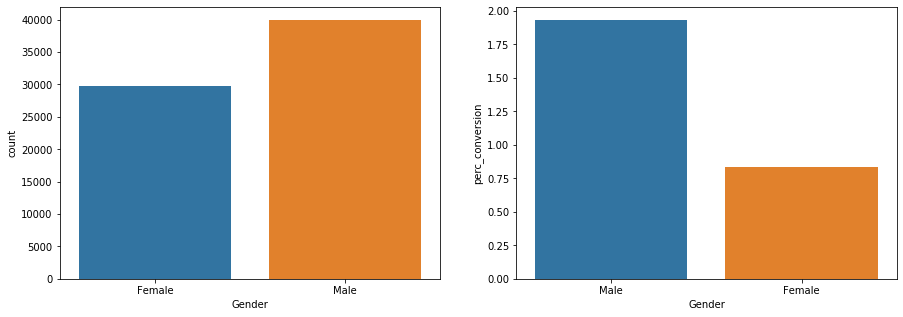

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(bank_df.Gender, ax=ax[0])
approved_df = bank_df[bank_df.Approved==1]
male_conv_perc = (approved_df[approved_df.Gender=='Male'].shape[0] / bank_df[bank_df.Gender=='Male'].shape[0])*100
female_conv_perc = (approved_df[approved_df.Gender=='Female'].shape[0] / bank_df[bank_df.Gender=='Female'].shape[0])*100
gender_conv_df = pd.DataFrame({'Gender':['Male', 'Female'], 'perc_conversion':[male_conv_perc, female_conv_perc]})
sns.barplot(gender_conv_df.Gender, gender_conv_df.perc_conversion, ax=ax[1])

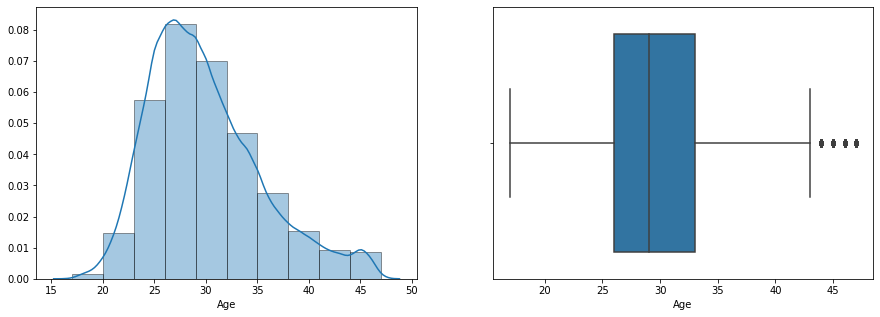

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(bank_df.Age, bins=10, hist_kws={'edgecolor':'black'}, ax=ax[0])
sns.boxplot(bank_df.Age)

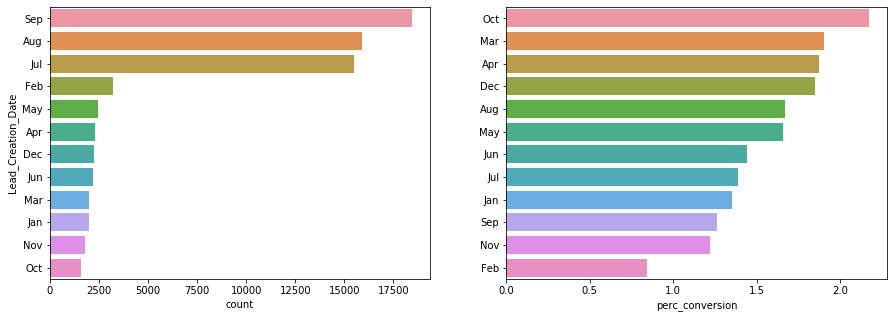

In [17]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(y=bank_df.Lead_Creation_Date.dt.strftime('%b'), 
              order=bank_df.Lead_Creation_Date.dt.strftime('%b').value_counts().index, ax=ax[0])
month_df = pd.DataFrame(bank_df.Lead_Creation_Date.dt.strftime('%b').value_counts())
month_app_df = pd.DataFrame(bank_df[bank_df.Approved==1].Lead_Creation_Date.dt.strftime('%b').value_counts())
month_conv_df = pd.merge(month_df, month_app_df, left_index=True, right_index=True)
month_conv_df['perc_conversion'] = round((month_conv_df.Lead_Creation_Date_y / month_conv_df.Lead_Creation_Date_x)*100,2)
month_conv_df = month_conv_df.sort_values('perc_conversion', ascending=False)
sns.barplot(y=month_conv_df.index, x=month_conv_df.perc_conversion, ax=ax[1])

In [18]:
def get_perc_conv_for_cat_features(col):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    sns.countplot(bank_df[col], ax=ax[0])
    actual_df = pd.DataFrame(bank_df[col].value_counts())
    approved_df = pd.DataFrame(bank_df[bank_df.Approved==1][col].value_counts())
    conv_df = pd.merge(actual_df, approved_df, left_index=True, right_index=True)
    conv_df['perc_conversion'] = round((conv_df[col+'_y'] / conv_df[col+'_x'])*100,2)
    conv_df = conv_df.sort_values('perc_conversion', ascending=False)
    sns.barplot(x=conv_df.index, y=conv_df.perc_conversion, ax=ax[1])

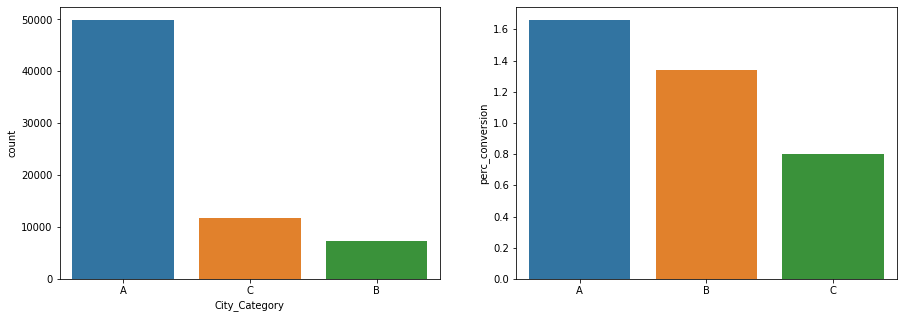

In [19]:
get_perc_conv_for_cat_features('City_Category')

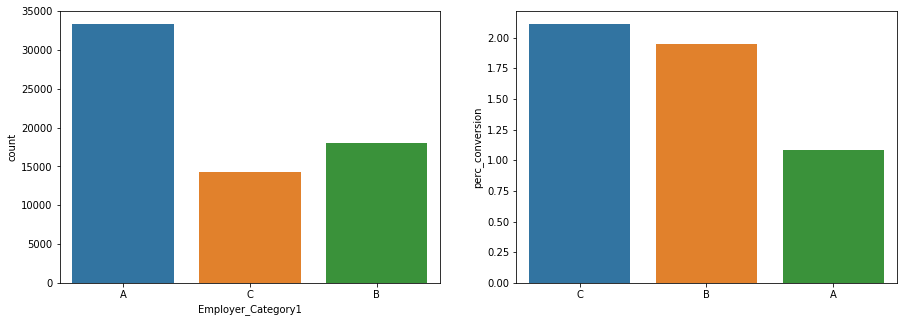

In [20]:
get_perc_conv_for_cat_features('Employer_Category1')

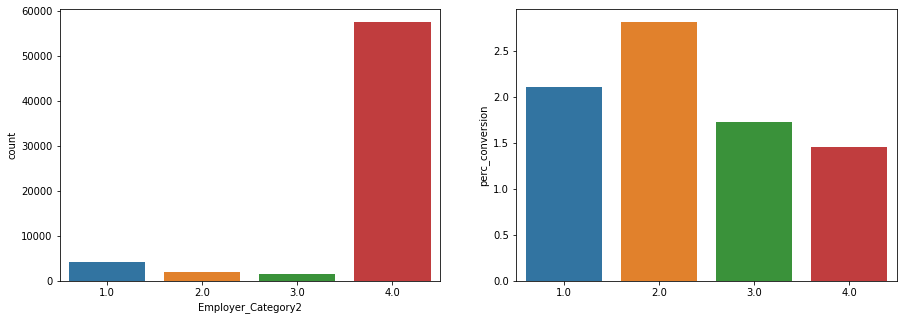

In [21]:
get_perc_conv_for_cat_features('Employer_Category2')

In [22]:
bank_df = bank_df[~(bank_df.Monthly_Income==0)]

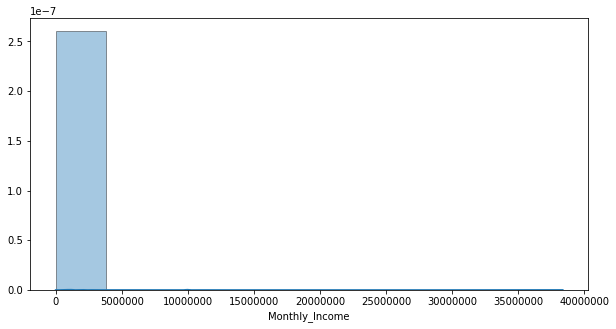

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.distplot(bank_df.Monthly_Income, bins=10, hist_kws={'edgecolor':'black'})
plt.ticklabel_format(style='plain', axis='x')

In [24]:
bank_df = bank_df[~(bank_df.Monthly_Income>=25000)]

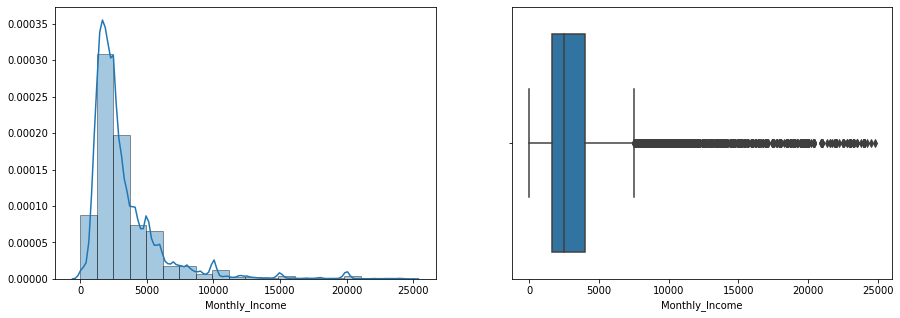

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.distplot(bank_df.Monthly_Income, bins=20, hist_kws={'edgecolor':'black'}, ax=ax[0])
sns.boxplot(bank_df.Monthly_Income, ax=ax[1])

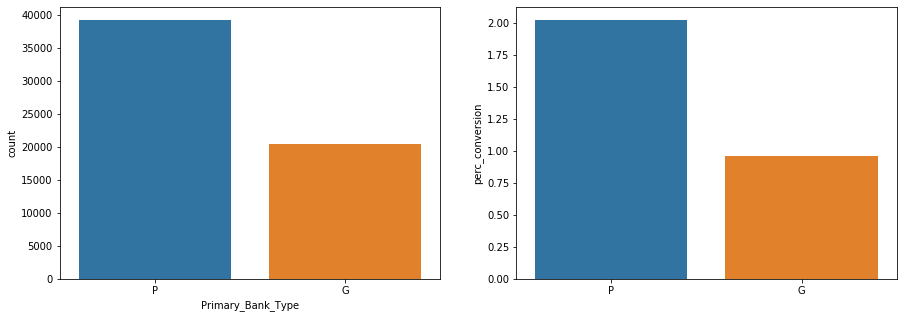

In [26]:
get_perc_conv_for_cat_features('Primary_Bank_Type')

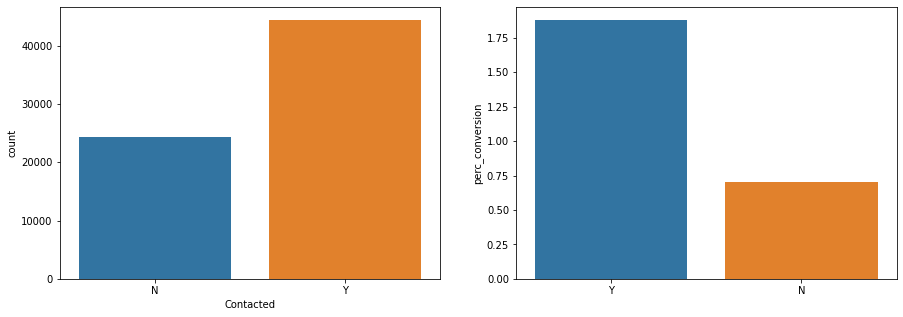

In [27]:
get_perc_conv_for_cat_features('Contacted')

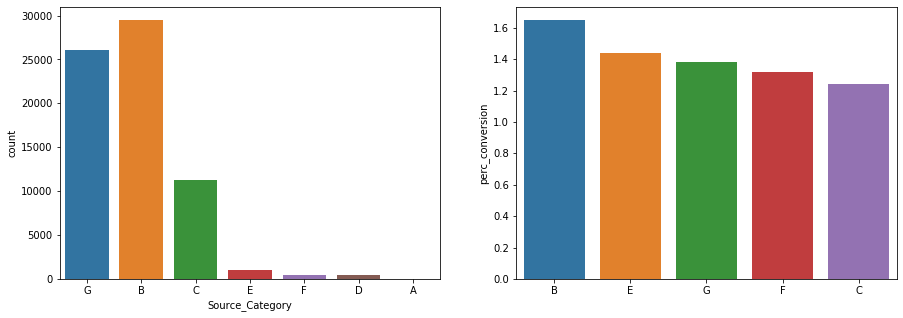

In [28]:
get_perc_conv_for_cat_features('Source_Category')

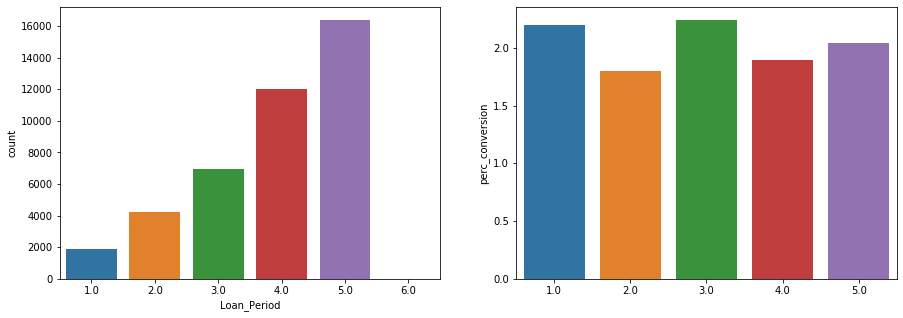

In [29]:
get_perc_conv_for_cat_features('Loan_Period')

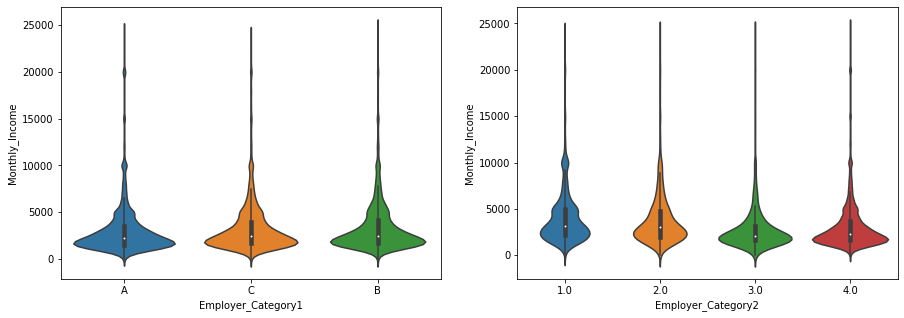

In [30]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.violinplot(bank_df.Employer_Category1, bank_df.Monthly_Income, ax=ax[0])
sns.violinplot(bank_df.Employer_Category2, bank_df.Monthly_Income, ax=ax[1])

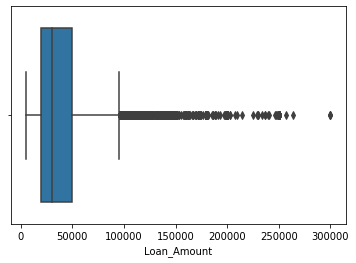

In [31]:
sns.boxplot(bank_df.Loan_Amount)

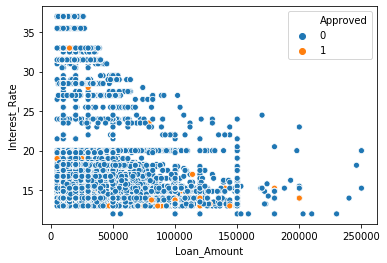

In [32]:
sns.scatterplot(bank_df.Loan_Amount, bank_df.Interest_Rate, hue=bank_df.Approved)

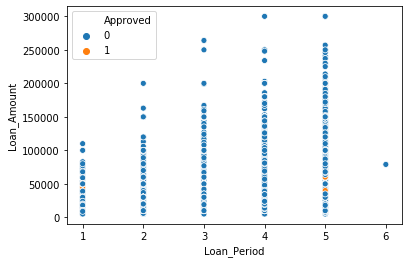

In [33]:
sns.scatterplot(y=bank_df.Loan_Amount, x=bank_df.Loan_Period, hue=bank_df.Approved)

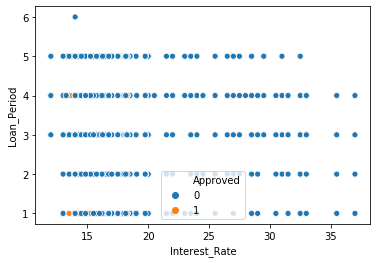

In [34]:
sns.scatterplot(y=bank_df.Loan_Period, x=bank_df.Interest_Rate, hue=bank_df.Approved)

In [35]:
bank_df = bank_df[~(bank_df.Interest_Rate>=35)]

In [36]:
bank_df.Monthly_Income = bank_df.Monthly_Income - bank_df.Existing_EMI

In [37]:
bank_df.drop(['Existing_EMI'], axis=1, inplace=True)

In [38]:
bank_df = bank_df[~(bank_df.EMI>=bank_df.Monthly_Income)]

In [39]:
def missing_val_perc(df):
    for col in df.columns:
        print("Percentage of missing values in " + col + ": " + str(round(bank_df[col].isna().sum()/bank_df.shape[0],2)))

In [40]:
missing_val_perc(df=bank_df)

Percentage of missing values in Gender: 0.0
Percentage of missing values in Lead_Creation_Date: 0.0
Percentage of missing values in City_Category: 0.01
Percentage of missing values in Employer_Category1: 0.06
Percentage of missing values in Employer_Category2: 0.06
Percentage of missing values in Monthly_Income: 0.0
Percentage of missing values in Primary_Bank_Type: 0.13
Percentage of missing values in Contacted: 0.0
Percentage of missing values in Source_Category: 0.0
Percentage of missing values in Loan_Amount: 0.4
Percentage of missing values in Loan_Period: 0.4
Percentage of missing values in Interest_Rate: 0.69
Percentage of missing values in EMI: 0.69
Percentage of missing values in Var1: 0.0
Percentage of missing values in Approved: 0.0
Percentage of missing values in Age: 0.04


In [41]:
index_nums = [index for index, val in enumerate(bank_df.isna().sum(axis=1)) if val>7]
bank_df.drop(bank_df.index[index_nums], inplace=True)

In [42]:
for col in ['City_Category', 'Employer_Category1', 'Employer_Category2', 'Primary_Bank_Type']:
    bank_df[col].fillna(bank_df[col].mode()[0], inplace=True)

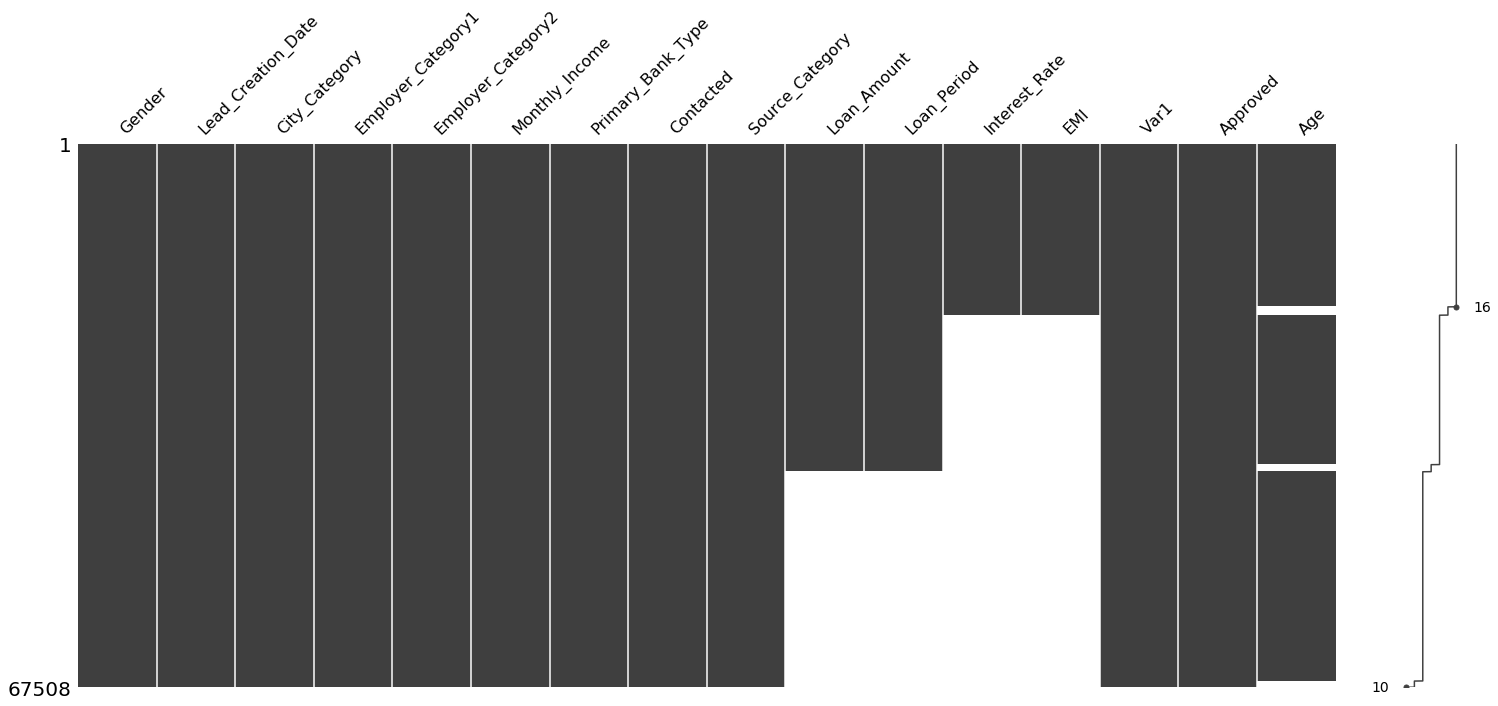

In [43]:
msno.matrix(bank_df, sort='descending')

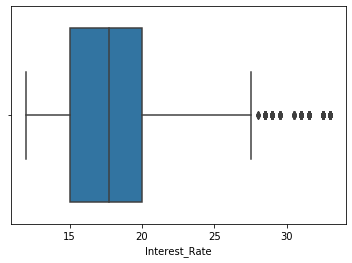

In [44]:
sns.boxplot(bank_df.Interest_Rate)

In [45]:
mask = bank_df[(~((bank_df.Loan_Amount.isna())&(bank_df.Loan_Period.isna())))&(bank_df.Interest_Rate.isna())].index
bank_df.loc[mask, 'Interest_Rate'] = bank_df.Interest_Rate.median()

In [46]:
def emi_calculator(principal, interest, period): 
    interest = interest / (12*100) 
    period = period * 12
    EMI = (principal * interest * pow(1+interest, period)) / (pow(1+interest, period)-1) 
    return round(EMI,0)

In [47]:
mask = bank_df[(~((bank_df.Loan_Amount.isna())&(bank_df.Loan_Period.isna())&(bank_df.Interest_Rate.isna())))
               &(bank_df.EMI.isna())].index
bank_df.loc[mask, 'EMI'] = emi_calculator(bank_df.Loan_Amount, bank_df.Interest_Rate, bank_df.Loan_Period)

In [48]:
bank_df = bank_df[~((bank_df.Monthly_Income.isna())|(bank_df.Monthly_Income==0))]

In [49]:
bank_df['Employer_Category'] = bank_df.Employer_Category1.astype(str) + bank_df.Employer_Category2.astype(int).astype(str)

In [50]:
bank_df.drop(['Employer_Category1', 'Employer_Category2'], axis=1, inplace=True)

In [51]:
bank_df[['City_Category','Source_Category',
         'Employer_Category']] = bank_df[['City_Category','Source_Category',
                                          'Employer_Category']].apply(LabelEncoder().fit_transform)

In [52]:
bank_df.Gender = bank_df.Gender.map({'Male':0,'Female':1})

In [53]:
bank_df.Primary_Bank_Type = bank_df.Primary_Bank_Type.map({'P':0,'G':1})
bank_df.Contacted = bank_df.Contacted.map({'N':0, 'Y':1})

In [54]:
bank_df['Lead_Creation_Day'] = bank_df.Lead_Creation_Date.dt.day
bank_df['Lead_Creation_Month'] = bank_df.Lead_Creation_Date.dt.month
bank_df.drop(['Lead_Creation_Date'], axis=1, inplace=True)

In [55]:
EMI_backup = bank_df.EMI

In [56]:
bank_df_impute = bank_df.drop(['EMI'], axis=1)
impute_cols = bank_df_impute.columns

In [57]:
iterative_imputer = IterativeImputer()
bank_df_impute = iterative_imputer.fit_transform(bank_df_impute)

In [58]:
bank_df_impute = pd.DataFrame(bank_df_impute, columns=impute_cols)

In [59]:
bank_df_impute = bank_df_impute.join(EMI_backup)

In [60]:
bank_df_impute.Interest_Rate = bank_df_impute.Interest_Rate.apply(lambda x: round(x,0))

In [61]:
mask = bank_df_impute[bank_df_impute.EMI.isna()].index
bank_df_impute.loc[mask, 'EMI'] = emi_calculator(bank_df_impute.Loan_Amount, bank_df_impute.Interest_Rate, 
                                                 bank_df_impute.Loan_Period)

In [62]:
bank_df_impute = bank_df_impute[~(bank_df_impute.EMI>=bank_df_impute.Monthly_Income)]

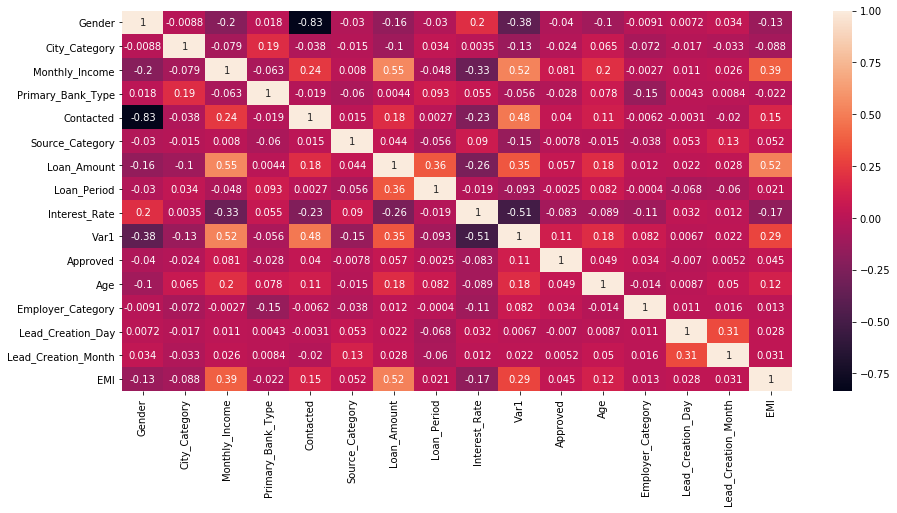

In [63]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.heatmap(bank_df_impute.corr(), annot=True)

# Logistic Regression

In [64]:
logit_df = bank_df_impute.copy(deep=True)

In [65]:
y_logit = logit_df['Approved']
X_logit = logit_df.drop(['Approved'], axis=1)

In [66]:
cat_cols = ['Gender', 'City_Category', 'Primary_Bank_Type', 'Contacted', 'Source_Category', 'Var1', 'Employer_Category']
for col in cat_cols:
    X_logit[col] = X_logit[col].astype('category')

In [67]:
num_cols = ['Monthly_Income', 'Loan_Amount', 'Loan_Period', 'Interest_Rate', 'Age', 'Lead_Creation_Day', 
            'Lead_Creation_Month', 'EMI']

In [68]:
dummies = pd.get_dummies(X_logit[cat_cols], drop_first=True)

In [69]:
col_names = num_cols
scaled_data = StandardScaler().fit_transform(X_logit[num_cols])
num_scaled_data = pd.DataFrame(scaled_data, columns=col_names, index=dummies.index)

In [70]:
X_std_logit = pd.concat([num_scaled_data, dummies], axis=1)

In [71]:
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X_std_logit, y_logit, test_size=0.3)

In [73]:
logit_model = LogisticRegression(class_weight='balanced', random_state=204)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=204)
best_logit = GridSearchCV(logit_model, param_grid={'max_iter':[100,300,500,1000], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
                          scoring='roc_auc', cv=kfold, n_jobs=-1)

In [74]:
best_logit.fit(X_train_logit, y_train_logit)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=204),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 300, 500, 1000]},
             scoring='roc_auc')

In [75]:
best_logit.best_params_

{'C': 0.001, 'max_iter': 100}

In [76]:
np.mean(cross_val_score(best_logit.best_estimator_, X_train_logit, y_train_logit, scoring='roc_auc', cv=kfold, n_jobs=-1))

0.7715640419719917

In [77]:
final_logit = LogisticRegression(class_weight='balanced', C=0.001, max_iter=300, random_state=204)

In [78]:
final_logit.fit(X_train_logit, y_train_logit)

LogisticRegression(C=0.001, class_weight='balanced', max_iter=300,
                   random_state=204)

In [79]:
logit_predictions = final_logit.predict(X_test_logit)

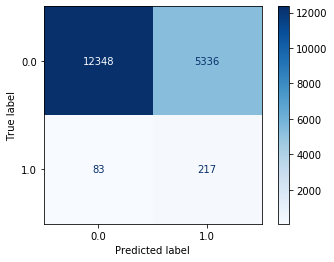

In [80]:
plot_confusion_matrix(final_logit, X_test_logit, y_test_logit, cmap=plt.cm.Blues)

In [82]:
print(classification_report(y_test_logit, logit_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82     17684
         1.0       0.04      0.72      0.07       300

    accuracy                           0.70     17984
   macro avg       0.52      0.71      0.45     17984
weighted avg       0.98      0.70      0.81     17984



# Naive Bayes Classifier

In [83]:
navie_df = bank_df_impute.copy(deep=True)

In [84]:
cat_cols = ['Gender', 'City_Category', 'Primary_Bank_Type', 'Contacted', 'Source_Category', 'Var1', 'Approved', 
            'Employer_Category']
for col in cat_cols:
    navie_df[col] = navie_df[col].astype('category')

In [85]:
y_naive = navie_df['Approved']
X_naive = navie_df.drop(['Approved'], axis=1)

In [86]:
X_train_naive, X_test_naive, y_train_naive, y_test_naive = train_test_split(X_naive, y_naive, test_size=0.3)

In [93]:
naive_model = GaussianNB()

In [94]:
naive_model.fit(X_train_naive, y_train_naive)

GaussianNB()

In [95]:
naive_predictions = naive_model.predict(X_test_naive)

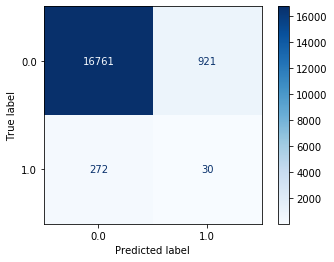

In [96]:
plot_confusion_matrix(naive_model, X_test_naive, y_test_naive, cmap=plt.cm.Blues)

In [97]:
print(classification_report(y_test_naive, naive_predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     17682
         1.0       0.03      0.10      0.05       302

    accuracy                           0.93     17984
   macro avg       0.51      0.52      0.51     17984
weighted avg       0.97      0.93      0.95     17984



# Random Forest Model

In [65]:
rf_df = bank_df_impute.copy(deep=True)

In [67]:
cat_cols = ['Gender', 'City_Category', 'Primary_Bank_Type', 'Contacted', 'Source_Category', 'Var1', 'Approved', 
            'Employer_Category']
for col in cat_cols:
    rf_df[col] = rf_df[col].astype('category')

In [68]:
y = rf_df['Approved']
X = rf_df.drop(['Approved'], axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [72]:
for estimator in range(50,1550,50):
    rf_model = RandomForestClassifier(n_estimators=estimator, random_state=204)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=204)
    print("Estimator " + str(estimator)+ ": " + 
          str(np.mean(cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='roc_auc'))))

Estimator 50: 0.7383767947367943
Estimator 100: 0.767574188571943
Estimator 150: 0.7790703296304982
Estimator 200: 0.7830749228811584
Estimator 250: 0.7881174817505616
Estimator 300: 0.7899773689736346
Estimator 350: 0.7912560557402128
Estimator 400: 0.7930259946394441
Estimator 450: 0.7942033972302023
Estimator 500: 0.7943990564445285
Estimator 550: 0.7945459618707387
Estimator 600: 0.7952107838328512
Estimator 650: 0.7958622554336999
Estimator 700: 0.7961572624010087
Estimator 750: 0.7972367875642211
Estimator 800: 0.797245688208611
Estimator 850: 0.7974065874526264
Estimator 900: 0.7976700178343393
Estimator 950: 0.7981204628368981
Estimator 1000: 0.7988435191293213
Estimator 1050: 0.7989481579957841
Estimator 1100: 0.7991910504311213
Estimator 1150: 0.7996279755824526
Estimator 1200: 0.7998076452346485
Estimator 1250: 0.8002502047166369
Estimator 1300: 0.799948249871451
Estimator 1350: 0.7999791067300215
Estimator 1400: 0.8000277025292781
Estimator 1450: 0.7997328892647854
Estimato

In [115]:
rf_model_1 = RandomForestClassifier(n_estimators=550, oob_score=True, class_weight='balanced', random_state=204)
best_rfm_1 = GridSearchCV(rf_model_1, param_grid={'max_depth':[None,6,14,20], 'max_features':['sqrt','log2',None]},
                        cv=kfold, scoring='roc_auc', n_jobs=-1)

In [116]:
best_rfm_1.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=550, oob_score=True,
                                              random_state=204),
             n_jobs=-1,
             param_grid={'max_depth': [None, 6, 14, 20],
                         'max_features': ['sqrt', 'log2', None]},
             scoring='roc_auc')

In [117]:
best_rfm_1.best_params_

{'max_depth': 6, 'max_features': 'sqrt'}

In [118]:
np.mean(cross_val_score(best_rfm_1.best_estimator_, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8137092720005328

In [120]:
rf_model_2 = RandomForestClassifier(n_estimators=550, oob_score=True, class_weight='balanced',
                                    max_depth=6, max_features='sqrt', random_state=204)
best_rfm_2 = GridSearchCV(rf_model_2, param_grid={'min_samples_leaf':[1,2,3,6,10], 'min_samples_split':[2,10,100,200]},
                        cv=kfold, scoring='roc_auc', n_jobs=-1)

In [121]:
best_rfm_2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=6, max_features='sqrt',
                                              n_estimators=550, oob_score=True,
                                              random_state=204),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3, 6, 10],
                         'min_samples_split': [2, 10, 100, 200]},
             scoring='roc_auc')

In [122]:
best_rfm_2.best_params_

{'min_samples_leaf': 10, 'min_samples_split': 200}

In [123]:
np.mean(cross_val_score(best_rfm_2.best_estimator_, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8140061530425851

In [124]:
final_rf_model = RandomForestClassifier(n_estimators=550, class_weight='balanced', max_depth=6, 
                                        max_features='sqrt', min_samples_leaf=10, min_samples_split=200, 
                                        oob_score=True, random_state=204)

In [125]:
np.mean(cross_val_score(final_rf_model, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8140061530425851

In [126]:
final_rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=200, n_estimators=550, oob_score=True,
                       random_state=204)

In [127]:
rf_predictions = final_rf_model.predict(X_test)

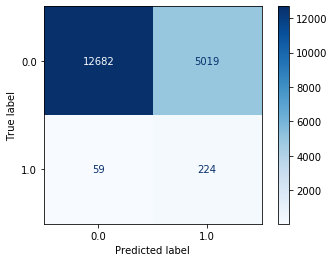

In [128]:
plot_confusion_matrix(final_rf_model, X_test, y_test, cmap=plt.cm.Blues)

In [130]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83     17701
         1.0       0.04      0.79      0.08       283

    accuracy                           0.72     17984
   macro avg       0.52      0.75      0.46     17984
weighted avg       0.98      0.72      0.82     17984



# Xtreme Gradient Boosting Model